<a href="https://colab.research.google.com/github/troberts60/Molecular-Solubility/blob/main/Mol_Solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict Solubility of Molecules

#1. Import rdkit

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-06-28 23:58:14--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   226MB/s    in 0.4s    

2021-06-28 23:58:14 (226 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

# 2. Get Data

In [2]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2021-06-27 19:56:54--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.002s  

2021-06-27 19:56:54 (34.1 MB/s) - ‘delaney.csv’ saved [58889/58889]



# 3. Read Data

In [2]:
import pandas as pd

In [3]:
solub = pd.read_csv('solub_data.csv')
solub

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


#4. Input Data to rdkit object

In [5]:
from rdkit import Chem

molList = []
for element in solub.smiles:
  mol = Chem.MolFromSmiles(element)
  molList.append(mol)

In [6]:
len(molList)

1128

## 5. Calculate LogP, Molecular Weight and Rotatable Bonds

In [7]:
import numpy as np
from rdkit.Chem import Descriptors

In [8]:

# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def create(smiles, verbose=False):

    mData = []
    for elem in smiles:
        mole=Chem.MolFromSmiles(elem)
        mData.append(mole)
    
    tData= np.arange(1,1)
    i=0
    for mol in mData:
        logP = Descriptors.MolLogP(mol)
        molWt = Descriptors.MolWt(mol)
        nrb = Descriptors.NumRotatableBonds(mol)

        row = np.array([logP,molWt,nrb])

        if(i==0):
          tData=row
        else:
          tData=np.vstack([tData, row])
        i=i+1

    colNames = ["MolLogP","MolWt","NumRotatableBonds"]
    descriptors = pd.DataFrame(data=tData,columns= colNames)

    return descriptors

In [9]:
d = create(solub.smiles)
d

,MolLogP,MolWt,NumRotatableBonds
0,-3.10802,457.432,7.0
1,2.84032,201.225,2.0
2,2.87800,152.237,4.0
3,6.29940,278.354,0.0
4,1.74810,84.143,0.0
...,...,...,...
1123,2.50850,197.381,0.0
1124,0.10710,219.266,1.0
1125,2.99000,246.359,7.0
1126,2.05240,72.151,1.0


#Aromatic Molecules

In [10]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
aroAtoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aroAtoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [11]:
def AroAt(m):
  aroAtoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aaCount = []
  for i in aroAtoms:
    if i==True:
      aaCount.append(1)
  sum_aaCount = sum(aaCount)
  return sum_aaCount

In [12]:
AroAt(m)

19

In [13]:
aroList = [AroAt(element) for element in molList]
aroList

[6,
 11,
 0,
 22,
 5,
 9,
 12,
 6,
 0,
 12,
 0,
 10,
 0,
 6,
 0,
 0,
 0,
 6,
 6,
 0,
 12,
 6,
 0,
 6,
 6,
 0,
 9,
 0,
 12,
 0,
 6,
 0,
 12,
 0,
 12,
 0,
 12,
 6,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 6,
 12,
 6,
 10,
 0,
 0,
 18,
 6,
 12,
 6,
 0,
 10,
 18,
 0,
 12,
 0,
 0,
 6,
 11,
 12,
 6,
 6,
 0,
 12,
 5,
 12,
 0,
 6,
 0,
 0,
 12,
 12,
 0,
 11,
 0,
 10,
 0,
 6,
 6,
 0,
 18,
 0,
 0,
 12,
 6,
 0,
 16,
 0,
 10,
 12,
 6,
 12,
 6,
 6,
 0,
 10,
 0,
 0,
 10,
 0,
 6,
 6,
 0,
 9,
 6,
 12,
 0,
 6,
 14,
 9,
 10,
 6,
 6,
 12,
 0,
 0,
 6,
 6,
 0,
 0,
 6,
 12,
 6,
 0,
 6,
 0,
 6,
 0,
 0,
 6,
 6,
 0,
 6,
 10,
 0,
 6,
 0,
 10,
 6,
 10,
 0,
 0,
 0,
 6,
 9,
 6,
 0,
 0,
 0,
 0,
 6,
 0,
 6,
 6,
 6,
 18,
 0,
 6,
 12,
 0,
 12,
 12,
 0,
 6,
 6,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 6,
 0,
 18,
 16,
 0,
 6,
 0,
 6,
 6,
 0,
 6,
 0,
 6,
 6,
 0,
 10,
 11,
 0,
 0,
 6,
 0,
 12,
 0,
 0,
 6,
 0,
 0,
 9,
 10,
 6,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 6,
 0,
 6,
 12,
 20,
 6,
 10,
 6,
 10,
 12,
 5,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 12,


In [14]:
aroPorport = [AroAt(element)/Descriptors.HeavyAtomCount(element) for element in molList]
aroPorport

[0.1875,
 0.7333333333333333,
 0.0,
 1.0,
 1.0,
 1.0,
 0.7058823529411765,
 0.3,
 0.0,
 0.41379310344827586,
 0.0,
 0.9090909090909091,
 0.0,
 0.375,
 0.0,
 0.0,
 0.0,
 0.75,
 0.3157894736842105,
 0.0,
 0.7058823529411765,
 0.35294117647058826,
 0.0,
 0.46153846153846156,
 0.2727272727272727,
 0.0,
 0.6923076923076923,
 0.0,
 0.6666666666666666,
 0.0,
 0.6,
 0.0,
 0.5454545454545454,
 0.0,
 0.8571428571428571,
 0.0,
 0.9230769230769231,
 0.35294117647058826,
 0.0,
 0.0,
 0.9230769230769231,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5454545454545454,
 0.8,
 0.24,
 0.8333333333333334,
 0.0,
 0.0,
 1.0,
 0.42857142857142855,
 0.6666666666666666,
 0.75,
 0.0,
 0.8333333333333334,
 0.9473684210526315,
 0.0,
 0.6,
 0.0,
 0.0,
 0.75,
 0.5789473684210527,
 0.46153846153846156,
 0.4,
 0.6666666666666666,
 0.0,
 0.8571428571428571,
 0.29411764705882354,
 0.6666666666666666,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.42857142857142855,
 0.8,
 0.0,
 0.5,
 0.0,
 0.9090909090909091,
 0.0,
 0.75,
 0.6,
 0.0,
 

In [15]:
df_aroProp = pd.DataFrame(aroPorport, columns=['AromaticProp'])
df_aroProp

,AromaticProp
0,0.187500
1,0.733333
2,0.000000
3,1.000000
4,1.000000
...,...
1123,0.000000
1124,0.000000
1125,0.000000
1126,0.000000


In [16]:
X = pd.concat([d, df_aroProp], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProp
0,-3.10802,457.432,7.0,0.187500
1,2.84032,201.225,2.0,0.733333
2,2.87800,152.237,4.0,0.000000
3,6.29940,278.354,0.0,1.000000
4,1.74810,84.143,0.0,1.000000
...,...,...,...,...
1123,2.50850,197.381,0.0,0.000000
1124,0.10710,219.266,1.0,0.000000
1125,2.99000,246.359,7.0,0.000000
1126,2.05240,72.151,1.0,0.000000


In [17]:
Y = solub.iloc[:,8]
Y

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
m1 = linear_model.LinearRegression()
m1.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#X-train

In [21]:
Y_pred_train = m1.predict(X_train)

In [22]:
print('Coefficents: ', m1.coef_)
print('Intercept: ', m1.intercept_)
print('MSE: %.2f' % mean_squared_error(Y_train, Y_pred_train))
print('R^2: %.2f' % r2_score(Y_train,Y_pred_train))


Coefficents:  [-0.74666331 -0.0065521   0.00918651 -0.3901604 ]
Intercept:  0.21988343978938296
MSE: 1.04
R^2: 0.76


#X-test

In [23]:
Y_pred_test = m1.predict(X_test)

In [24]:
print('Coefficents: ', m1.coef_)
print('Intercept: ', m1.intercept_)
print('MSE: %.2f' % mean_squared_error(Y_test, Y_pred_test))
print('R^2: %.2f' % r2_score(Y_test,Y_pred_test))

Coefficents:  [-0.74666331 -0.0065521   0.00918651 -0.3901604 ]
Intercept:  0.21988343978938296
MSE: 0.93
R^2: 0.78


#Linear Model Equation

In [26]:
yinter = '%.2f' % m1.intercept_
logP = '%.2f LogP' % m1.coef_[0]
mw = '%.4f MW' % m1.coef_[1]
rb = '%.4f RB' % m1.coef_[2]
ap = '%.2f AP' % m1.coef_[3]

In [27]:
print( 'LogS = '+ ' ' + yinter + ' ' + logP + ' ' + mw + ' ' + rb + ' ' + ap)

LogS =  0.22 -0.75 LogP -0.0066 MW 0.0092 RB -0.39 AP


#Full Data Set

In [28]:
fd = linear_model.LinearRegression()
fd.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
full_pred = m1.predict(X)

In [30]:
print('Coefficents: ', fd.coef_)
print('Intercept: ', fd.intercept_)
print('MSE: %.2f' % mean_squared_error(Y, full_pred))
print('R^2: %.2f' % r2_score(Y,full_pred))

Coefficents:  [-0.74538848 -0.0065345   0.00255623 -0.42238747]
Intercept:  0.25486750179712203
MSE: 1.02
R^2: 0.77


In [31]:
f_yinter = '%.2f' % fd.intercept_
f_logP = '%.2f LogP' % fd.coef_[0]
f_mw = '%.4f MW' % fd.coef_[1]
f_rb = '%.4f RB' % fd.coef_[2]
f_ap = '%.2f AP' % fd.coef_[3]

In [32]:
print( 'LogS = '+ ' ' + f_yinter + ' ' + f_logP + ' ' + f_mw + ' ' + f_rb + ' ' + f_ap)

LogS =  0.25 -0.75 LogP -0.0065 MW 0.0026 RB -0.42 AP


#Plot Graph

In [33]:
import matplotlib.pyplot as plt

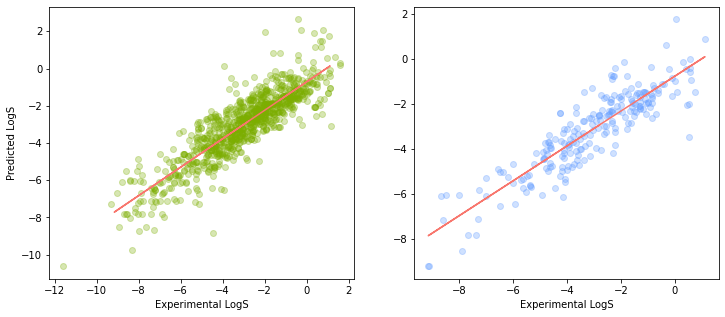

In [34]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(x=Y_train, y=Y_pred_train, c='#7CAE00', alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
t = np.polyfit(Y_train,Y_pred_train, 1)
r = np.poly1d(t)
plt.plot(Y_test,r(Y_test), "#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.subplot(1,2,2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

t = np.polyfit(Y_test,Y_pred_test,1)
r = np.poly1d(t)
plt.plot(Y_test,r(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()